<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

1.941474245120387
ISE:  0.0036491335596008753


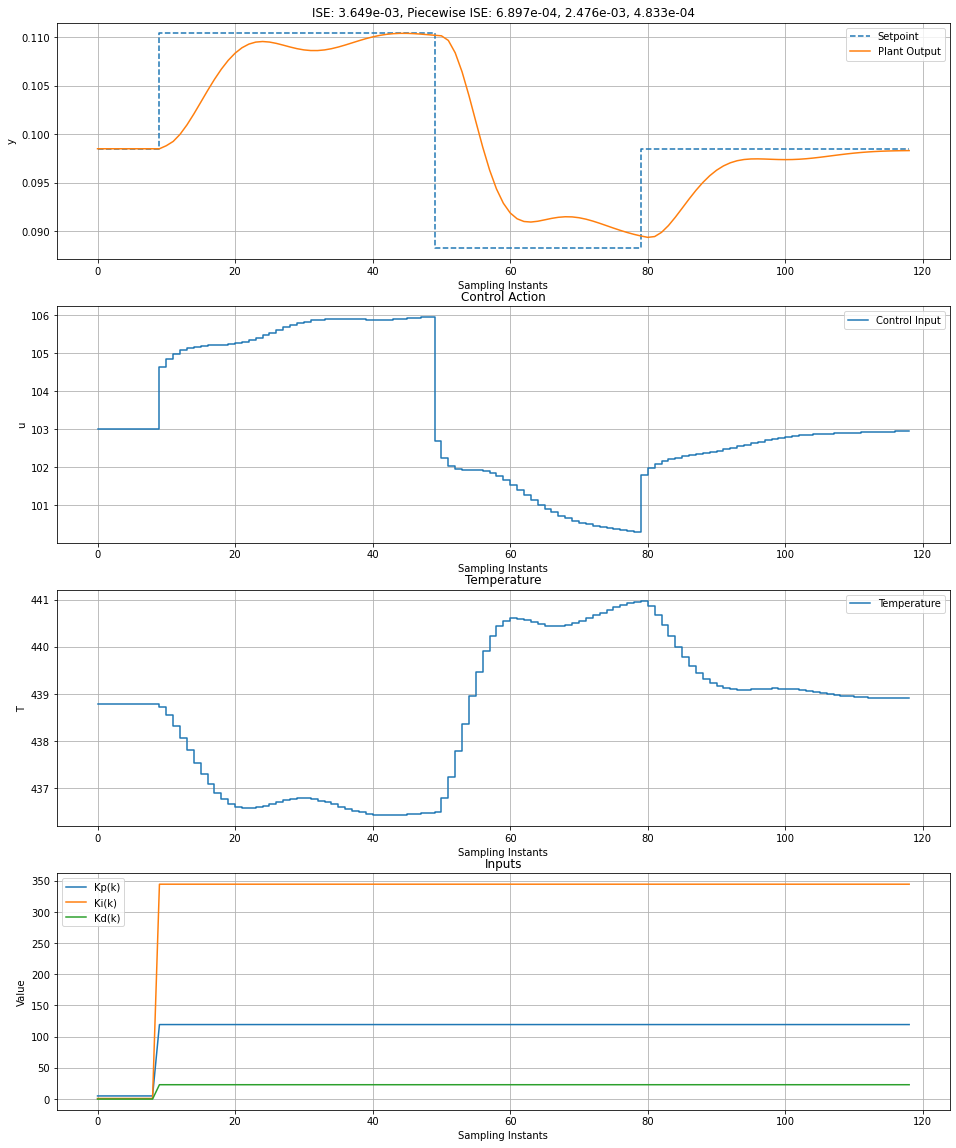

In [138]:
from calculate_cstr import get_init_states

import gym
import matplotlib.pyplot as plt
import numpy as np
from control.matlab import *
from gym import spaces
from scipy.integrate import solve_ivp
from simple_pid import PID
import os
import cv2
import io

uinit = 103.0
umin = 95.0
umax = 112.0
# Tinit = 438.7763
# Tinit = 438.86881957
# yinit = 0.09849321
# yinit, Tinit = get_init_states(uinit)
delt = 0.083
slew_rate = None

Kp = 119.4321
taui = 0.3367
taud = 0.1926
Ki = Kp / taui
Kd = Kp * taud


def fig2data(fig, dpi=72):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @param dpi DPI of saved image
    @return a numpy 3D array of RGBA values
    """
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


class CSTR:
    def __init__(
        self,
        uinit=uinit,
        Tinit=Tinit,
        yinit=yinit,
        delt=delt,
        ttfinal=None,
        disturbance=True,
        deterministic=False,
    ):
        # Simulation settings
        self.delt = delt  # sample time
        self.ttfinal = ttfinal  # final simulation time
        self.ksp = 10
        self.slew_rate = slew_rate
        self.umin = umin
        self.umax = umax
        self.input_low = np.array([self.umin])
        self.input_high = np.array([self.umax])
        self.reset_init(uinit, Tinit, yinit, ttfinal,
                        disturbance, deterministic)

    @property
    def state_names(self):
        names = names = ["Setpoint(k)", "Output(k)", "Output(k-1)",
                         "Temp(k)", "Temp(k-1)", "Model Region(k)"]
        assert len(names) == self.n_states
        return names

    @property
    def input_names(self):
        names = ["Input(k)"]
        assert len(names) == self.n_actions
        return names

    @property
    def n_states(self):
        return len(self.get_state())

    @property
    def n_actions(self):
        return self.input_low.shape[0]

    def reset_init(
        self,
        uinit=uinit,
        Tinit=Tinit,
        yinit=yinit,
        ttfinal=None,
        disturbance=True,
        deterministic=False,
    ):
        #  plant initial conditions
        self.uinit = uinit
        self.Tinit = Tinit
        self.yinit = yinit

        self.disturbance = disturbance
        if deterministic:
            self.r = np.concatenate(
                (
                    np.ones((self.ksp, 1)) * self.yinit,
                    np.ones((40, 1)) * 0.11038855,
                    np.ones((30, 1)) * 0.08823159,
                    np.ones((40, 1)) * 0.09849321,
                )
            )
        else:
            self.uinit = np.random.randint(100.0, 108.0)
            self.yinit, self.Tinit = get_init_states(self.uinit)
            self.r = np.concatenate(
                (
                    np.ones((self.ksp, 1)) * self.yinit,
                    np.ones((40, 1)) * np.random.uniform(0.07, 0.10),
                    np.ones((30, 1)) * np.random.uniform(0.07, 0.14),
                    np.ones((40, 1)) * np.random.uniform(0.09, 0.14),
                )
            )
        sim_time = len(self.r) * self.delt
        self.ttfinal = ttfinal if ttfinal is not None and ttfinal < sim_time else sim_time
        self.tt = np.arange(0, self.ttfinal, self.delt)  # time vector
        self.kfinal = len(self.tt)  # number of time intervals

        return self.reset()

    def reset_env(self):
        # Reset sim time
        self.tinitial = 0
        self.tfinal = self.tinitial + self.delt
        self.k = self.ksp - 1
        # Input vector
        self.u = np.zeros((self.kfinal + 1, 1))
        self.u[: self.ksp] = np.ones((self.ksp, 1)) * self.uinit
        self.du = np.zeros((self.kfinal, 1))
        # Output vector
        self.y = np.zeros((self.kfinal + 1, 1))
        self.y[: self.ksp] = np.ones((self.ksp, 1)) * self.yinit
        # Temperature Vector
        self.T = np.zeros((self.kfinal + 1, 1))
        self.T[: self.ksp] = np.ones((self.ksp, 1)) * self.Tinit
        # Error vector
        self.E = np.zeros((self.kfinal, 1))
        # State Vector
        self.x = [self.yinit, self.Tinit]
        # Model Vector
        self.m = np.zeros((self.kfinal + 1, 1))
        self.m[: self.ksp] = np.ones((self.ksp, 1)) * self.get_model_region()
        return self.r[self.k][0], self.y[self.k][0]

    def reset(self):
        # Input vector
        self.input = np.zeros((self.kfinal + 1, self.n_actions))
        self.input[: self.ksp] = np.ones((self.ksp, 1)) * self.uinit
        return self.reset_env()

    def dec_ode(self, u):
        def ode_eqn(t, z):
            qc = u
            q = 100.0
            Cao = 1.0
            To = 350.0
            Tco = 350.0
            V = 100.0
            hA = 7e5
            ko = 7.2e10
            AE = 1e4
            delH = 2e5
            rho = 1e3
            rhoc = 1e3
            Cp = 1.0
            Cpc = 1.0
            Ca = z[0]
            T = z[1]
            Ca = np.maximum(1e-6, Ca)
            T = np.maximum(10, T)
            qc = np.maximum(1e-4, qc)
            try:
                f1 = (q / V * (Cao - Ca)) - (ko * Ca * np.exp(-AE / T))
                f2 = (
                    (q / V * (To - T))
                    - ((((-delH) * ko * Ca) / (rho * Cp)) * np.exp(-AE / T))
                    + (((rhoc * Cpc) / (rho * Cp * V)) * qc *
                       (1 - np.exp(-hA / (qc * rho * Cp))) * (Tco - T))
                )
            except RuntimeWarning:
                print("qc: ", qc)
                print("Ca: ", Ca)
                print("T: ", T)
                raise RuntimeError
            return [f1, f2]

        return ode_eqn

    def step_env(self, u):
        self.E[self.k] = self.r[self.k][0] - self.y[self.k][0]
        # Slew rate
        if self.slew_rate:
            u = np.clip(u, self.u[self.k - 1] - self.slew_rate,
                        self.u[self.k - 1] + self.slew_rate)
        # Disturbance
        d = 0.05 * np.random.randn() if self.disturbance else 0.0
        self.u[self.k] = u + d
        # Control Constraints
        self.u[self.k] = np.clip(self.u[self.k], self.umin, self.umax)
        # Solve ODE and update state vector and output vector
        sol = solve_ivp(self.dec_ode(self.u[self.k]), [
                        self.tinitial, self.tfinal], self.x)
        self.x[0] = sol.y[0][-1]
        self.x[1] = sol.y[1][-1]
        self.y[self.k + 1] = self.x[0]
        self.T[self.k + 1] = self.x[1]
        # Current model region
        self.m[self.k] = self.get_model_region()
        # Update time and sampling instant
        self.tinitial = self.tfinal
        self.tfinal += self.delt
        self.k = self.k + 1
        return self.r[self.k][0], self.y[self.k][0]

    def step(self, u):
        self.input[self.k] = np.array(u)
        return self.step_env(u)

    def get_state(self):
        return (
            self.r[self.k][0] - yinit,
            self.y[self.k][0] - yinit,
            self.y[self.k - 1][0] - yinit,
            self.T[self.k][0] - Tinit,
            self.T[self.k - 1][0] - Tinit,
            self.m[self.k - 1][0],
        )

    def plot(self, save=False, use_sample_instant=True):
        axis = self.tt[: self.k].copy()
        axis_name = "Time"
        if use_sample_instant:
            axis = np.arange(self.k)
            axis_name = "Sampling Instants"
        plt.figure(figsize=(16, 20))
        plt.subplot(4, 1, 1)
        plt.step(
            axis,
            self.r[: self.k],
            linestyle="dashed",
            label="Setpoint",
        )
        ise = f"{self.ise():.3e}"
        piecewise_ise = "{:.3e}, {:.3e}, {:.3e}".format(
            *self.get_piecewise_ise())
        title = f"ISE: {ise}, Piecewise ISE: {piecewise_ise}"
        plt.plot(axis, self.y[: self.k], label="Plant Output")
        plt.ylabel("y")
        plt.xlabel(axis_name)
        plt.title(title)
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.step(axis, self.u[: self.k], label="Control Input")
        plt.ylabel("u")
        plt.xlabel(axis_name)
        plt.title("Control Action")
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.step(axis, self.T[: self.k], label="Temperature")
        plt.ylabel("T")
        plt.xlabel(axis_name)
        plt.title("Temperature")
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 4)
        for i in range(self.n_actions):
            plt.plot(axis, self.input[: self.k, i],
                     label=self.input_names[i])
        plt.ylabel("Value")
        plt.xlabel(axis_name)
        plt.title("Inputs")
        plt.grid()
        plt.legend()
        if save:
            plt.tight_layout()
            img = fig2data(plt.gcf())
            plt.close()
            return img

    def get_model_region(self):
        m_values = np.linspace(-0.2, 0.2, 6)
        m = m_values[0]
        if self.u[self.k] >= 97.0 and self.u[self.k] <= 100.0:
            m = m_values[1]
        elif self.u[self.k] > 100.0 and self.u[self.k] <= 103.0:
            m = m_values[2]
        elif self.u[self.k] > 103.0 and self.u[self.k] <= 106.0:
            m = m_values[3]
        elif self.u[self.k] > 106.0 and self.u[self.k] <= 109.0:
            m = m_values[4]
        elif self.u[self.k] > 109.0:
            m = m_values[5]
        return m

    def plot_model_regions(self, use_sample_instant=True):
        axis = self.tt[: self.k].copy()
        axis_name = "Time"
        if use_sample_instant:
            axis = np.arange(self.k)
            axis_name = "Sampling Instants"
        plt.figure(figsize=(12, 6))
        plt.plot(axis, self.m[: self.k])
        plt.title("Model Region")
        plt.xlabel(axis_name)
        plt.ylabel("Linear Region Number")
        plt.grid()
        plt.show()

    def ise(self):
        return ((self.r[: self.k] - self.y[: self.k]) ** 2).sum()

    def get_piecewise_ise(self):
        return (
            ((self.r[10:50] - self.y[10:50]) ** 2).sum(),
            ((self.r[50:80] - self.y[50:80]) ** 2).sum(),
            ((self.r[80:120] - self.y[80:120]) ** 2).sum(),
        )


min_gains = [0.0, 0.0, 0.0]
max_gains = [140.0, 2.0, 2.0]


class CSTRPID(CSTR):
    @property
    def input_names(self):
        return ["Kp(k)", "Ki(k)", "Kd(k)"]

    def reset(self, *args, **kwargs):
        auto = False
        self.Gc = PID(
            Kp, Ki, Kd, setpoint=self.yinit, sample_time=self.delt, output_limits=(
                self.umin, self.umax), auto_mode=auto
        )
        self.Gc.set_auto_mode(not auto, last_output=self.uinit)
        self.slew_rate = None
        self.input_low = np.array(min_gains)
        self.input_high = np.array(max_gains)
        # Input vector
        self.input = np.zeros((self.kfinal + 1, self.n_actions))
        self.input[: self.ksp] = np.ones(
            (self.ksp, self.n_actions)) * np.array([5, 1, 0])

        self.gains = []
        self.gain_components = []
        return self.reset_env(*args, **kwargs)

    def step(self, Kp, taui, taud):
        Ki = Kp / (taui + 1e-2)
        Kd = Kp * taud
        self.Gc.setpoint = self.r[self.k][0]
        self.Gc.tunings = (Kp, Ki, Kd)
        u = self.Gc(self.y[self.k][0], self.delt)

        self.input[self.k] = np.array([Kp, Ki, Kd])
        self.gains.append([Kp, taui, taud])
        self.gain_components.append(self.Gc.components)
        return self.step_env(u)

    def plot_gains(self, use_sample_instant=True):
        axis = self.tt[: self.k].copy()
        axis_name = "Time"
        if use_sample_instant:
            axis = np.arange(self.k)
            axis_name = "Sampling Instants"
        plt.figure(figsize=(16, 9))
        plt.subplot(3, 1, 1)
        plt.plot(axis[: len(self.gains)],
                 np.array(self.gains)[:, 0], label="Kp")
        plt.ylabel("Value")
        plt.xlabel(axis_name)
        plt.grid()
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(axis[: len(self.gains)], np.array(
            self.gains)[:, 1], label="taui")
        plt.ylabel("Value")
        plt.xlabel(axis_name)
        plt.grid()
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(axis[: len(self.gains)], np.array(
            self.gains)[:, 2], label="taud")
        plt.ylabel("Value")
        plt.xlabel(axis_name)
        plt.grid()
        plt.legend()

    def plot_gain_components(self, use_sample_instant=True):
        axis = self.tt[: self.k].copy()
        axis_name = "Time"
        if use_sample_instant:
            axis = np.arange(self.k)
            axis_name = "Sampling Instants"
        plt.figure(figsize=(16, 9))
        plt.subplot(3, 1, 1)
        plt.plot(axis[: len(self.gain_components)], np.array(
            self.gain_components)[:, 0], label="Proportional")
        plt.ylabel("Value")
        plt.xlabel(axis_name)
        plt.grid()
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(axis[: len(self.gain_components)], np.array(
            self.gain_components)[:, 1], label="Integral")
        plt.ylabel("Value")
        plt.xlabel(axis_name)
        plt.grid()
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(axis[: len(self.gain_components)], np.array(
            self.gain_components)[:, 2], label="Derivative")
        plt.ylabel("Value")
        plt.xlabel(axis_name)
        plt.grid()
        plt.legend()


class GymCSTR(gym.Env):
    def __init__(
        self,
        uinit=uinit,
        Tinit=Tinit,
        yinit=yinit,
        system=CSTRPID,
        disturbance=True,
        deterministic=True,
    ):
        super().__init__()
        self.uinit = uinit
        self.Tinit = Tinit
        self.yinit = yinit
        self.disturbance = disturbance
        self.deterministic = deterministic

        self.system = system(
            uinit=self.uinit,
            Tinit=self.Tinit,
            yinit=self.yinit,
            disturbance=self.disturbance,
            deterministic=self.deterministic,
        )

        self.n_actions = self.system.n_actions
        self.action_space = spaces.Box(-1.0, 1.0, (self.n_actions,))
        self.n_states = self.system.n_states
        self.observation_space = spaces.Box(
            low=-2.0, high=2.0, shape=(self.n_states,), dtype=np.float32)

    def convert_state(self):
        obs = self.system.get_state()
        obs = np.array(obs).astype(np.float32)
        return obs

    def convert_action(self, action):
        actions = (action + 1) * (self.system.input_high -
                                  self.system.input_low) * 0.5 + self.system.input_low
        actions = np.clip(actions, self.system.input_low,
                          self.system.input_high)
        return actions

    def unconvert_action(self, action):
        actions = (2.0 * action - (self.system.input_high + self.system.input_low)) / (
            self.system.input_high - self.system.input_low
        )
        actions = np.clip(actions, -1.0, 1.0)
        return actions

    def reset(self):
        _ = self.system.reset()
        obs = self.convert_state()
        return obs

    def step(self, action, debug=False):
        if debug:
            print("Original: ", action)
        action = self.convert_action(action)
        if debug:
            print("Converted: ", action)
        obs = self.system.step(*action)
        # Calculate error and reward
        e = obs[0] - obs[1]
        scale = 15.0
        e_squared = scale * np.abs(e) ** 2
        e_squared = np.minimum(e_squared, 10.0)
        tol = (0.1 - np.abs(e)) if np.abs(e) <= 5e-4 else 0.0
        reward = -e_squared + tol
        done = bool(self.system.k == self.system.kfinal - 1)
        info = {}
        obs = self.convert_state()
        return obs, reward, done, info

    def render(self, mode="human"):
        if mode == "human":
            print("ISE: ", self.system.ise())
            self.system.plot()
        elif mode == "rgb_array":
            return self.system.plot(save=True)

    def close(self):
        pass


env_name = "CSTRPID-v0"
if env_name in gym.envs.registry.env_specs:
    del gym.envs.registry.env_specs[env_name]
gym.envs.register(
    id=env_name,
    entry_point="cstr_control_env:GymCSTR",
)

if __name__ == "__main__":
    args = {
        # "system": CSTR,
        "disturbance": False,
        "deterministic": True,
    }
    env = GymCSTR(**args)
    obss = []
    obs = env.reset()
    obss.append(obs)
    done = False
    tot_r = 0.0
    u = 108.0
    while not done:
        # obs, r, done, _ = env.step(env.unconvert_action(np.array([u])))
        obs, r, done, _ = env.step(
            env.unconvert_action(np.array([Kp, taui, taud])))
        tot_r += r
        obss.append(obs)
    print(tot_r)
    env.render()
    # plt.show()
    # env.system.plot_gains()
    # plt.show()
    # env.system.plot_gain_components()
    # print(env.system.y[env.system.k])
    # print(env.system.T[env.system.k])
    plt.show()

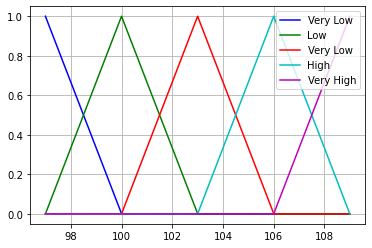

In [95]:
import skfuzzy as fuzz

q_range = np.arange(97, 109, 0.001)

# Generate fuzzy membership functions
very_low = fuzz.trimf(q_range, [97, 97, 100])
low = fuzz.trimf(q_range, [97, 100, 103])
medium = fuzz.trimf(q_range, [100, 103, 106])
high = fuzz.trimf(q_range, [103, 106, 109])
very_high = fuzz.trimf(q_range, [106, 109, 109])

plt.plot(q_range, very_low, 'b', linewidth=1.5, label='Very Low')
plt.plot(q_range, low, 'g', linewidth=1.5, label='Low')
plt.plot(q_range, medium, 'r', linewidth=1.5, label='Very Low')
plt.plot(q_range, high, 'c', linewidth=1.5, label='High')
plt.plot(q_range, very_high, 'm', linewidth=1.5, label='Very High')
plt.grid()
plt.legend()

In [96]:
q = 105.0
m1 = fuzz.interp_membership(q_range, very_low, q)
m2 = fuzz.interp_membership(q_range, low, q)
m3 = fuzz.interp_membership(q_range, medium, q)
m4 = fuzz.interp_membership(q_range, high, q)
m5 = fuzz.interp_membership(q_range, very_high, q)

membership_fns = [very_low, low, medium, high, very_high]

print(m1, m2, m3, m4, m5)

0.0 0.0 0.3333333333333333 0.6666666666666666 0.0


In [128]:
lamda_value = 0.5
gains = [
    [119.4321/lamda_value, 0.3367, 0.1926],
    [92.6928/lamda_value, 0.2973, 0.2546],
    [67.4294/lamda_value, 0.2491, 0.3601],
    [43.2812/lamda_value, 0.1876, 0.5792],
    [19.1813/lamda_value, 0.1037, 1.3124]
]

pid_gains = np.array([[x[0], x[0]/x[1], x[0]*x[1]] for x in gains])
pid_gains

array([[238.8642    , 709.42738343,  80.42557614],
       [185.3856    , 623.56407669,  55.11513888],
       [134.8588    , 541.38418306,  33.59332708],
       [ 86.5624    , 461.42004264,  16.23910624],
       [ 38.3626    , 369.93828351,   3.97820162]])

In [133]:
sim = CSTR(disturbance=False, deterministic=True)
sim.reset()

(0.09849321, 0.09849321)

In [99]:
from simple_pid import PID
pids = []
# print(sim.yinit, sim.)
for i in range(5):
    pid = PID(*pid_gains[i], setpoint=sim.yinit, sample_time=sim.delt, output_limits=(sim.umin, sim.umax), auto_mode=False)
    pid.set_auto_mode(True, sim.uinit)
    pids.append(pid)

In [134]:
proportional = pid_gains[:, 0] * (sim.E[sim.k] - sim.E[sim.k - 1])
integral = pid_gains[:, 1] * sim.delt * sim.E[sim.k]
derivative = (pid_gains[:, 2] / sim.delt) * (sim.E[sim.k] - 2 * sim.E[sim.k - 1] + sim.E[sim.k - 2])

In [135]:
proportional, integral, derivative

(array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0.]))

q:  103.0
h:  [0.0000000e+00 9.5496941e-12 1.0000000e+00 9.5496941e-12 0.0000000e+00]
u_action:  103.0
q:  103.0
h:  [0.0000000e+00 9.5496941e-12 1.0000000e+00 9.5496941e-12 0.0000000e+00]
u_action:  109.76855999006123
q:  109.76855999006123
h:  [0.         0.         0.         0.03333333 0.96666667]
u_action:  109.37855149175508
q:  109.37855149175508
h:  [0.         0.         0.         0.03333333 0.96666667]
u_action:  109.46335944660595
q:  109.46335944660595
h:  [0.         0.         0.         0.03333333 0.96666667]
u_action:  109.43402730520783
q:  109.43402730520783
h:  [0.         0.         0.         0.03333333 0.96666667]
u_action:  109.27786497761312
q:  109.27786497761312
h:  [0.         0.         0.         0.03333333 0.96666667]
u_action:  108.9936514695813
q:  108.9936514695813
h:  [0.         0.         0.         0.03333333 0.96666667]
u_action:  108.58719817657988
q:  108.58719817657988
h:  [0.         0.         0.         0.13760061 0.86239939]
u_action:  108.

q:  103.01168427357588
h:  [0.         0.         0.99610524 0.00389476 0.        ]
u_action:  103.04286322071204
q:  103.04286322071204
h:  [0.         0.         0.98571226 0.01428774 0.        ]
u_action:  103.06876554296973


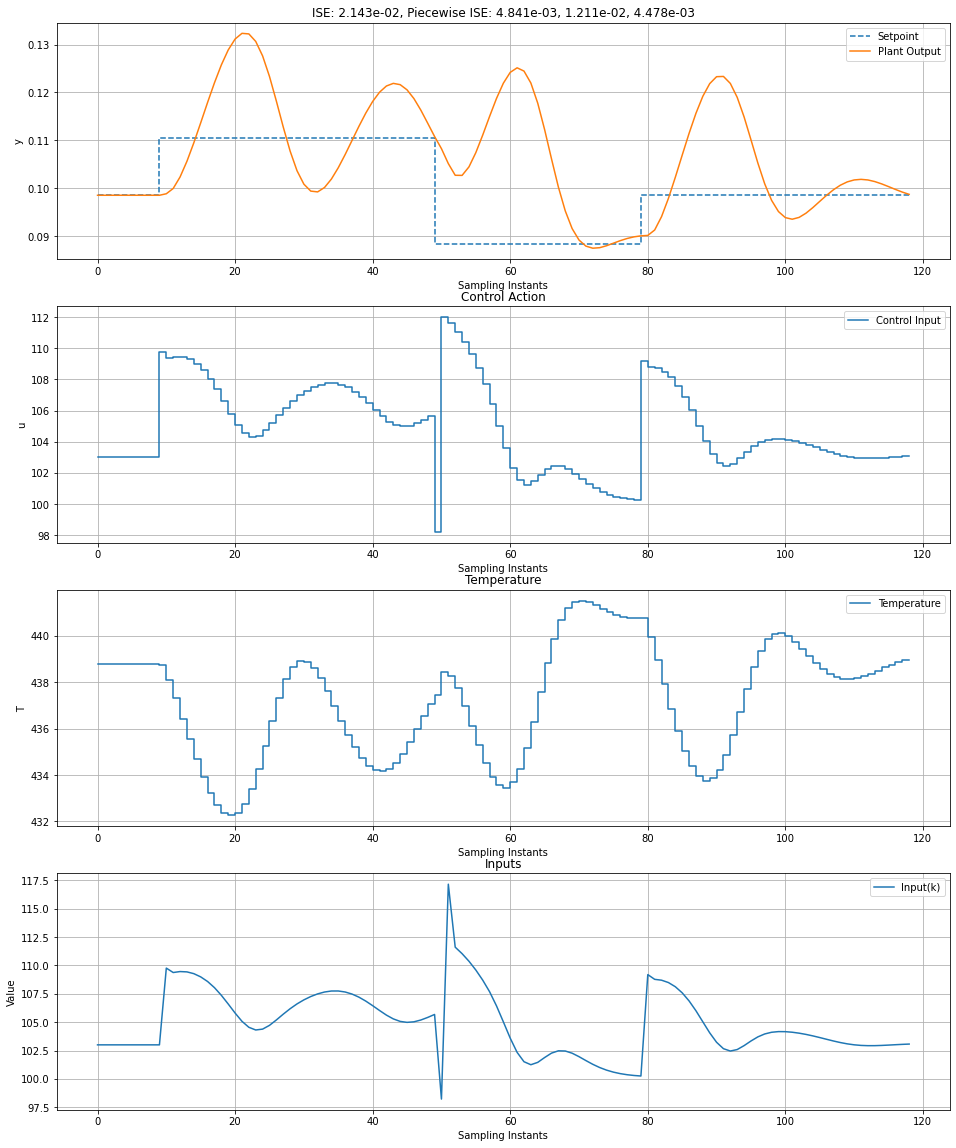

In [160]:
sim = CSTR(disturbance=False, deterministic=True)
r, y = sim.reset()
q = sim.u[sim.k-1]
us = []
hs = []
done = False
while not done:
    E = r - y
    proportional = pid_gains[:, 0] * (E - sim.E[sim.k - 1])
    integral = pid_gains[:, 1] * sim.delt * E
    derivative = (pid_gains[:, 2] / sim.delt) * (E - 2 * sim.E[sim.k - 1] + sim.E[sim.k - 2])
    du = proportional + integral + derivative
#     print(du)
    q = sim.u[sim.k-1][0]
#     print("du: ", du)
    print("q: ", q)
    u = q + du
#     print("u: ", u)
    h = np.array([fuzz.interp_membership(
        q_range, membership_fns[i], np.clip(q, 97.1, 108.9)) for i in range(5)])
    print("h: ", h)
    u_action = np.sum(u*h)
    print("u_action: ", u_action)
    r, y = sim.step(u_action)
    done = bool(sim.k == sim.kfinal - 1)

sim.plot()

ValueError: x and y can be no greater than 2-D, but have shapes (110,) and (110, 5, 1)

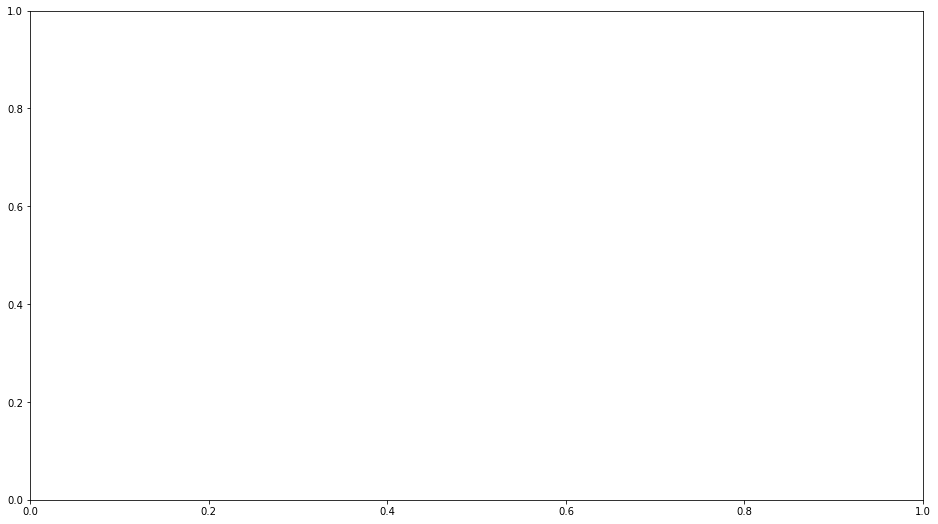

In [112]:
plt.figure(figsize=(16, 9))
plt.plot(np.arange(len(us))*sim.delt, us)
plt.grid()
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(np.arange(len(hs))*sim.delt, hs)
plt.grid()
plt.show()

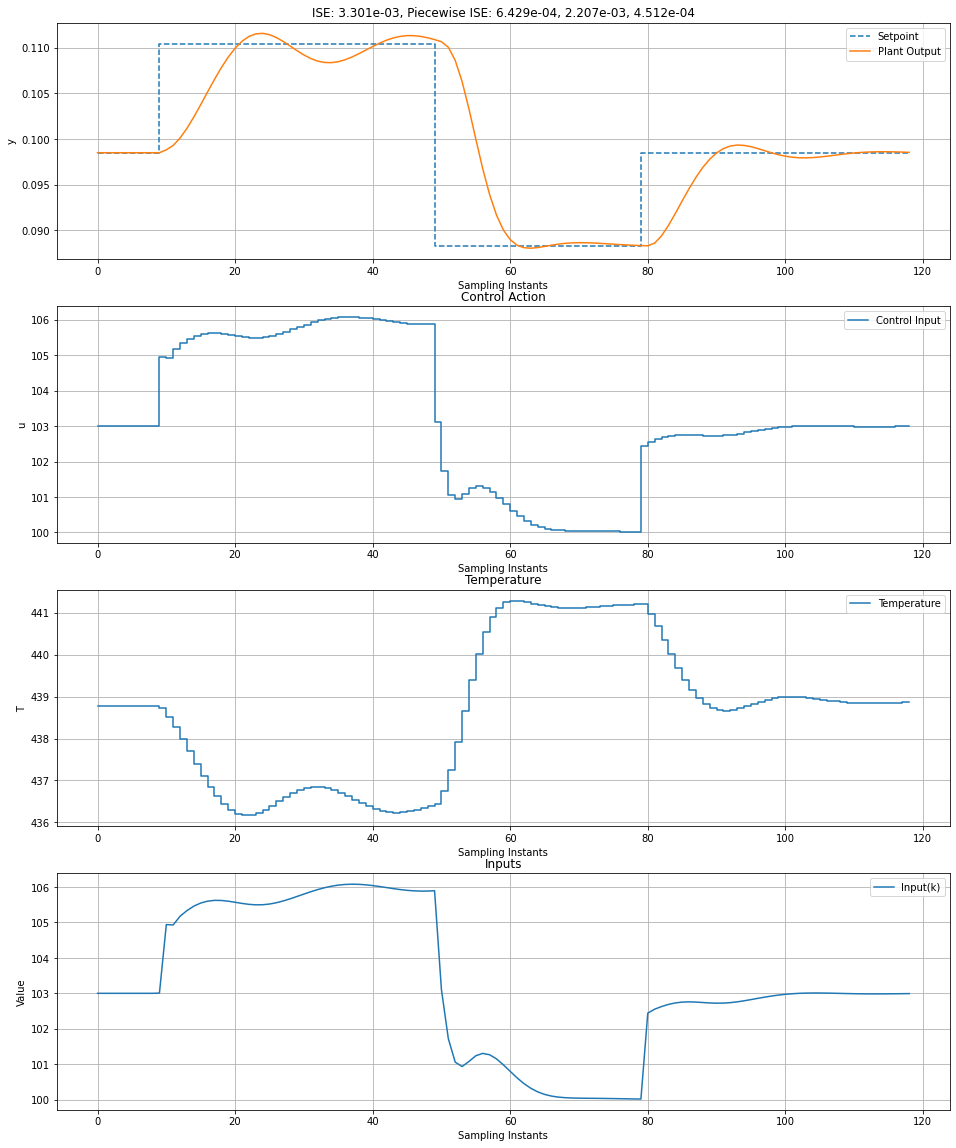

In [161]:
sim = CSTR(disturbance=False, deterministic=True)
r, y = sim.reset()
q = sim.u[sim.k-1]
us = []
hs = []
done = False
while not done:
    for i in range(5):
        pids[i].setpoint = r
    q = sim.u[sim.k-1]
    u = np.array([pids[i](y, sim.delt) for i in range(5)])
    h = np.array([fuzz.interp_membership(q_range, membership_fns[i], q)[0] for i in range(5)])
    us.append(u)
    hs.append(h)
    u_action = np.sum(u*h)
    r, y = sim.step(u_action)
    done = bool(sim.k == sim.kfinal - 1)

sim.plot()

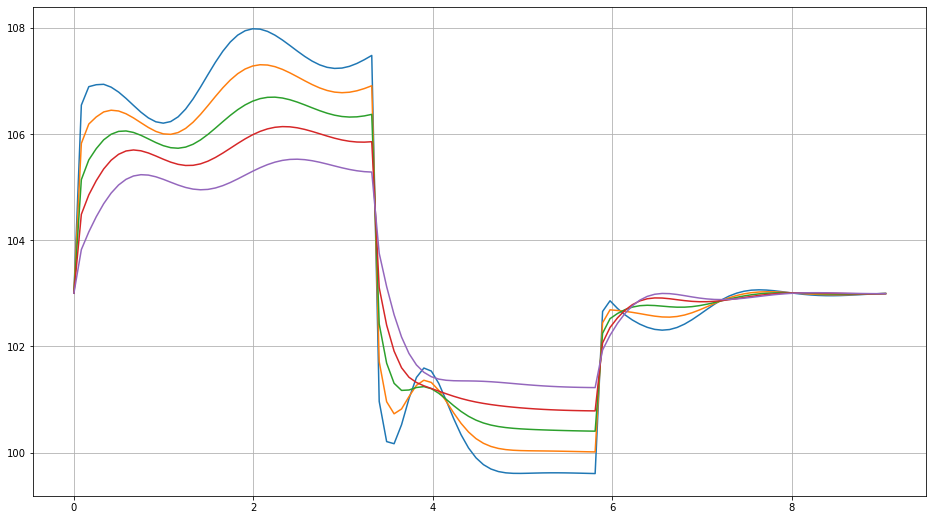

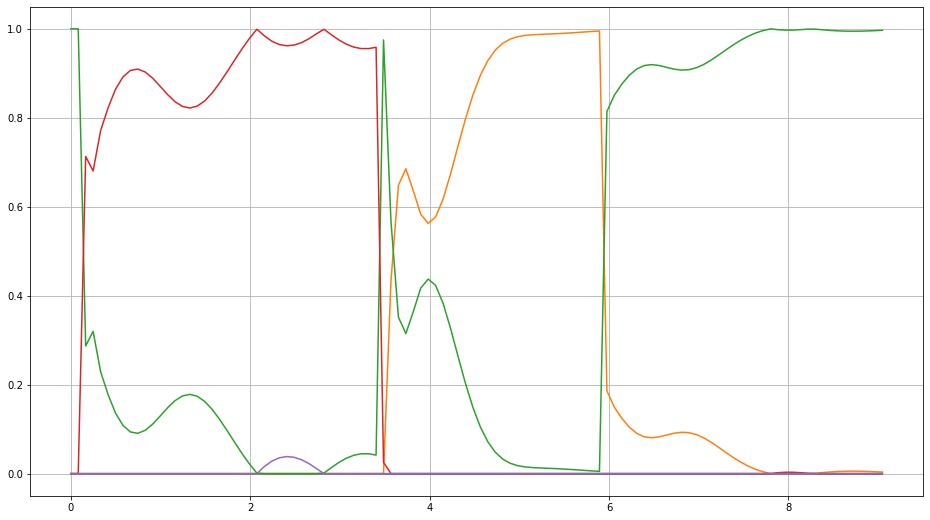

In [73]:
plt.figure(figsize=(16, 9))
plt.plot(np.arange(len(us))*sim.delt, us)
plt.grid()
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(np.arange(len(hs))*sim.delt, hs)
plt.grid()
plt.show()

In [ ]:
args = {
        "system": CSTR,
        "disturbance": False,
        "deterministic": False,
    }
env = GymCSTR(**args)
obss = []
obs = env.reset()
obss.append(obs)
done = False
tot_r = 0.0
u = 108.0
while not done:
    r, y = obs[:2]
    pid1.setpoint = r
    u = pid1(y, 0.083)
    obs, r, done, _ = env.step(env.unconvert_action(np.array([u])))
#     obs, r, done, _ = env.step(env.unconvert_action(np.array([Kp, taui, taud])))
    tot_r += r
    obss.append(obs)
print(tot_r)